In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from tqdm import tqdm
import mlflow.pytorch
import imgaug.augmenters as iaa
from pprint import pprint
import pandas as pd
import cv2

import mlflow

import matplotlib.pyplot as plt
%matplotlib inline

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from src.data import TrainValTestSplitter, MURASubset
from src.data.transforms import GrayScale, Padding, Resize, HistEqualisation, MinMaxNormalization, ToTensor
from src.features.augmentation import Augmentation
from src.models import BottleneckAutoencoder
from src.models.torchsummary import summary
from src import XR_HAND_CROPPED_PATH, MODELS_DIR, MLFLOW_TRACKING_URI, XR_HAND_PATH

/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## Helper function to get image in right format

In [2]:
size_sample = 20 # set how many image to be analysed

In [3]:
client = mlflow.tracking.MlflowClient(MLFLOW_TRACKING_URI)
client.list_experiments()

[<Experiment: artifact_location='/home/ubuntu/mlruns/2', experiment_id='2', lifecycle_stage='active', name='BottleneckAutoencoder'>,
 <Experiment: artifact_location='/home/ubuntu/mlruns/1', experiment_id='1', lifecycle_stage='active', name='BaselineAutoencoder'>,
 <Experiment: artifact_location='./mlruns/4', experiment_id='4', lifecycle_stage='active', name='DCGAN'>,
 <Experiment: artifact_location='./mlruns/3', experiment_id='3', lifecycle_stage='active', name='VAE'>]

In [4]:
run_id = 'f96ac2c1222841b595dda594cb6cd3f4'
experiment = client.get_experiment('1')
path = f'{experiment.artifact_location}/{run_id}/artifacts/baseline_autoencoder_aug_5/data/model.pth'
path
path_csv = f'{experiment.artifact_location}/{run_id}/artifacts/baseline_autoencoder_aug_5/data/evaluate_aug_5.csv'
path_loss = f'{experiment.artifact_location}/{run_id}/artifacts/baseline_autoencoder_aug_5/data/losses_aug_1_5.csv'

# 1. Augmentation: Flip, 500 Epoch

## 1.1 Get model

In [5]:
splitter = TrainValTestSplitter() 

run_params = {
    'batch_size': 32,
    'image_resolution': (512, 512),
    'num_epochs': 500,
    'batch_normalisation': True,
    'pipeline': {
        'hist_equalisation': True,
        'cropped': False,
    }
}

composed_transforms = Compose([GrayScale(),
                               Padding(),
                               Resize(run_params['image_resolution']),
                               HistEqualisation(active=run_params['pipeline']['hist_equalisation']),
                               MinMaxNormalization(),
                               ToTensor()])

validation = MURASubset(filenames=splitter.data_val.path, true_labels=splitter.data_val.label,
                        patients=splitter.data_val.patient, transform=composed_transforms)

data_path = XR_HAND_CROPPED_PATH if run_params['pipeline']['cropped'] else XR_HAND_PATH

num_workers = 6

device = "cpu"
model = torch.load(path, map_location=lambda storage, loc: storage)

outer_loss = nn.MSELoss(reduction='none')
model.eval().to(device)

=================Train subset=================
Size: 2846
Percentage from original data: 0.5134403752480606
Percentage of negatives: 1.0
Number of patients: 1017
=============Validation subset===============
Size: 1356
Percentage from original data: 0.24463287028684827
Percentage of negatives: 0.4837758112094395
Number of patients: 473
=================Test subset=================
Size: 1341
Percentage from original data: 0.2419267544650911
Percentage of negatives: 0.4153616703952274
Number of patients: 474


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'src.models.BaselineAutoencoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


BaselineAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (15): ReLU()
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU()
    (18): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (19): ReLU()
  )
  (decoder): Sequentia

In [6]:
composed_transforms = Compose([GrayScale(),
                               Padding(max_shape=(750, 750)),  # max_shape - max size of image after augmentation
                               Resize(run_params['image_resolution']),
                               HistEqualisation(active=run_params['pipeline']['hist_equalisation']),
                               MinMaxNormalization(),
                               ToTensor()])

# Dataset loaders
print(f'\nDATA SPLIT:')
splitter = TrainValTestSplitter(path_to_data=data_path)
validation = MURASubset(filenames=splitter.data_val.path, true_labels=splitter.data_val.label,
                        patients=splitter.data_val.patient, transform=composed_transforms)

val_loader = DataLoader(validation, batch_size=run_params['batch_size'], shuffle=True, num_workers=num_workers)


DATA SPLIT:
=================Train subset=================
Size: 2846
Percentage from original data: 0.5134403752480606
Percentage of negatives: 1.0
Number of patients: 1017
=============Validation subset===============
Size: 1356
Percentage from original data: 0.24463287028684827
Percentage of negatives: 0.4837758112094395
Number of patients: 473
=================Test subset=================
Size: 1341
Percentage from original data: 0.2419267544650911
Percentage of negatives: 0.4153616703952274
Number of patients: 474


## 1.2 Get data frame with losses and images from the last validation

In [7]:
augmentation_df_1 = pd.read_csv(path_csv)
print(augmentation_df_1)

      Unnamed: 0      Loss  True label  \
0              0  0.001679           0   
1              1  0.001445           0   
2              2  0.003211           0   
3              3  0.002007           0   
4              4  0.001394           0   
5              5  0.000913           0   
6              6  0.000926           1   
7              7  0.001428           1   
8              8  0.001084           1   
9              9  0.002506           1   
10            10  0.003960           1   
11            11  0.001728           0   
12            12  0.002206           1   
13            13  0.001873           0   
14            14  0.001472           1   
15            15  0.001178           0   
16            16  0.001229           1   
17            17  0.001279           0   
18            18  0.003001           1   
19            19  0.002503           0   
20            20  0.002649           1   
21            21  0.002278           0   
22            22  0.001051        

### 1.2.1 False Negative

In [8]:
false_negative = augmentation_df_1[augmentation_df_1['True label'] == 1].nsmallest(size_sample, 'Loss')
false_negative.style.set_properties(subset=['File name'], **{'width': '300px'})

In [9]:
files_false_negative_path = [x[3:] for x in false_negative['File name'] ]
files_false_negative = MURASubset(filenames=files_false_negative_path, transform=composed_transforms)

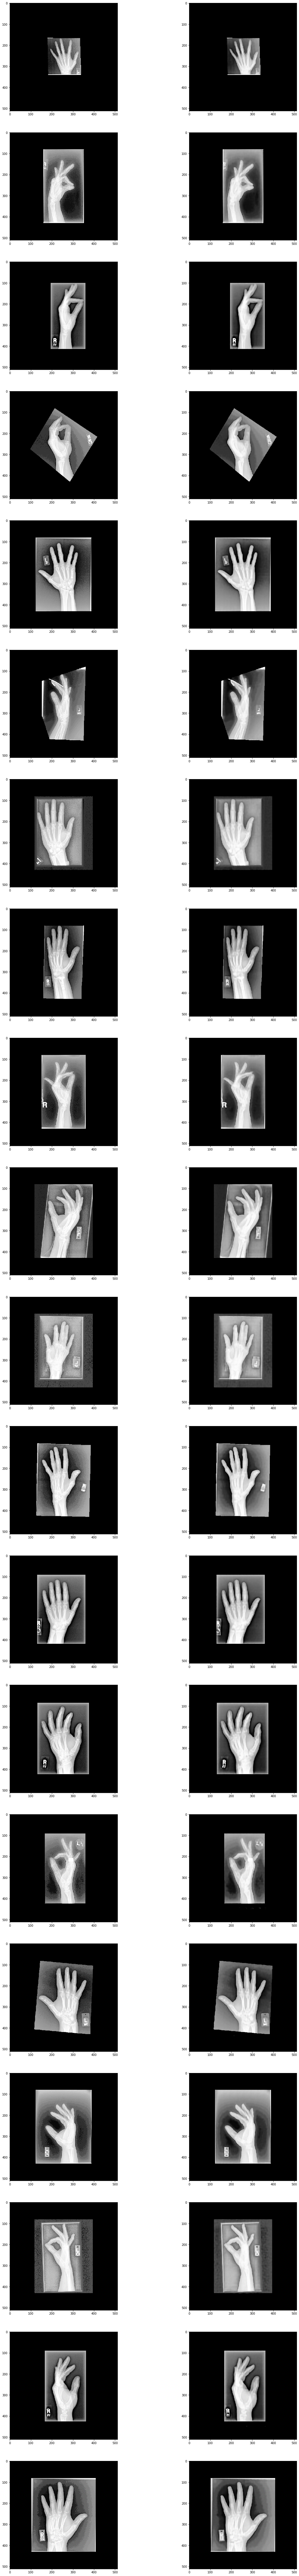

In [10]:
fig, ax = plt.subplots(nrows=size_sample, ncols=2, figsize=(20, 8*size_sample))

for i in range(size_sample):
    image_inp = files_false_negative[i]['image'][None,:,:,:]
    inp = image_inp.to(device)
    output = model(inp)
    
    ax[i, 0].imshow(image_inp.numpy()[0, 0, :, :], cmap='gray', vmin=0, vmax=1)
    ax[i, 1].imshow(output.detach().numpy()[0, 0, :, :], cmap='gray', vmin=0, vmax=1)

### 1.2.2 True Negative

In [11]:
true_negative = augmentation_df_1[augmentation_df_1['True label'] == 0].nsmallest(size_sample, 'Loss')
true_negative.style.set_properties(subset=['File name'], **{'width': '300px'})


In [12]:
files_true_negative_path = [x[3:] for x in true_negative['File name'] ]
files_true_negative = MURASubset(filenames=files_true_negative_path, transform=composed_transforms)

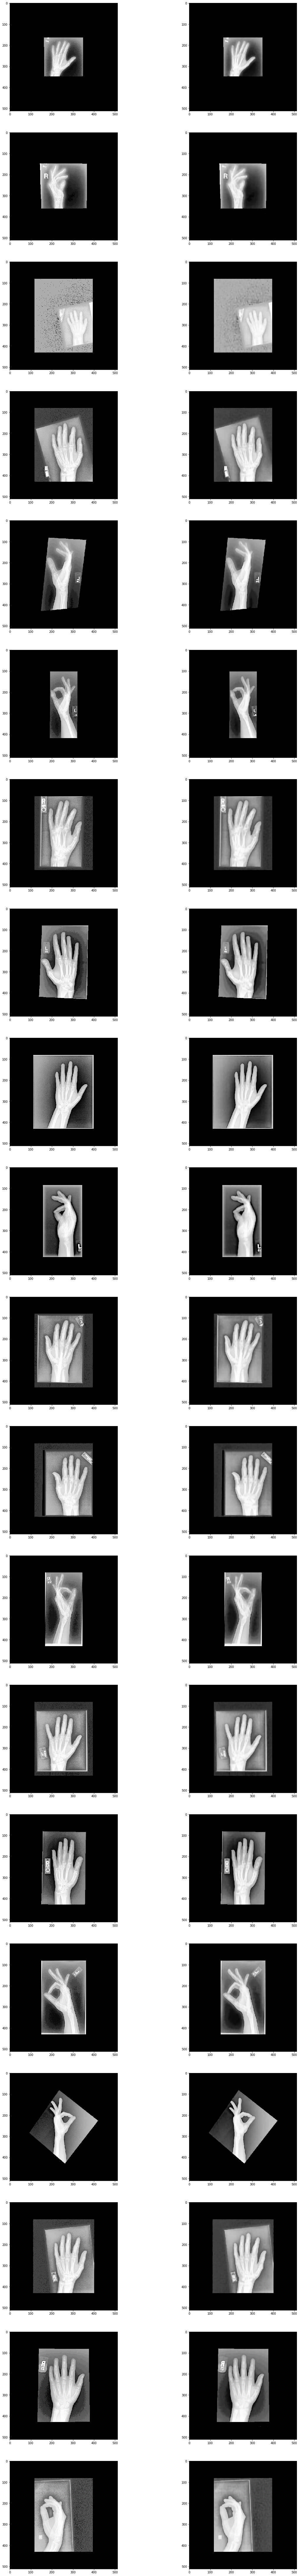

In [13]:
fig, ax = plt.subplots(nrows=size_sample, ncols=2, figsize=(20, 8*size_sample))

for i in range(size_sample):
    image_inp = files_true_negative[i]['image'][None,:,:,:]
    inp = image_inp.to(device)
    output = model(inp)
    
    ax[i, 0].imshow(image_inp.numpy()[0, 0, :, :], cmap='gray', vmin=0, vmax=1)
    ax[i, 1].imshow(output.detach().numpy()[0, 0, :, :], cmap='gray', vmin=0, vmax=1)

### 1.2.3 False Positive

In [14]:
false_positive = augmentation_df_1[augmentation_df_1['True label'] == 0].nlargest(size_sample, 'Loss')
false_positive.style.set_properties(subset=['File name'], **{'width': '300px'})

In [15]:
files_false_positive_path = [x[3:] for x in false_positive['File name'] ]
files_false_positive = MURASubset(filenames=files_false_positive_path, transform=composed_transforms)

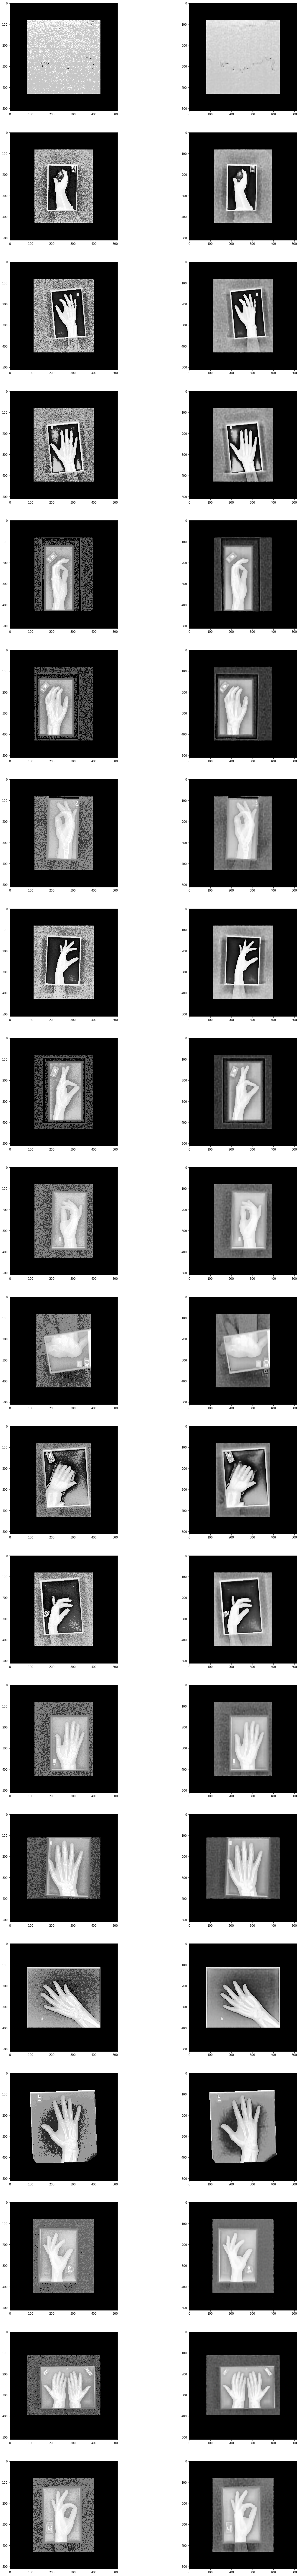

In [16]:
fig, ax = plt.subplots(nrows=size_sample, ncols=2, figsize=(20, 8*size_sample))

for i in range(size_sample):
    image_inp = files_false_positive[i]['image'][None,:,:,:]
    inp = image_inp.to(device)
    output = model(inp)
    
    ax[i, 0].imshow(image_inp.numpy()[0, 0, :, :], cmap='gray', vmin=0, vmax=1)
    ax[i, 1].imshow(output.detach().numpy()[0, 0, :, :], cmap='gray', vmin=0, vmax=1)

The images are missclassified because of:
 - black image without any hand
 - a lot of noise around the hand
 - complex labels that can not be reconstructed
 - some images have more rectangels around the hand
 - wired view on hand
 - hand in motion
 - brighness

### 1.2.4 True Positive

In [17]:
true_positive = augmentation_df_1[augmentation_df_1['True label'] == 1].nlargest(size_sample, 'Loss')
true_positive.style.set_properties(subset=['File name'], **{'width': '300px'})

In [18]:
files_true_positive_path = [x[3:] for x in true_positive['File name'] ]
files_true_positive = MURASubset(filenames=files_true_positive_path, transform=composed_transforms)

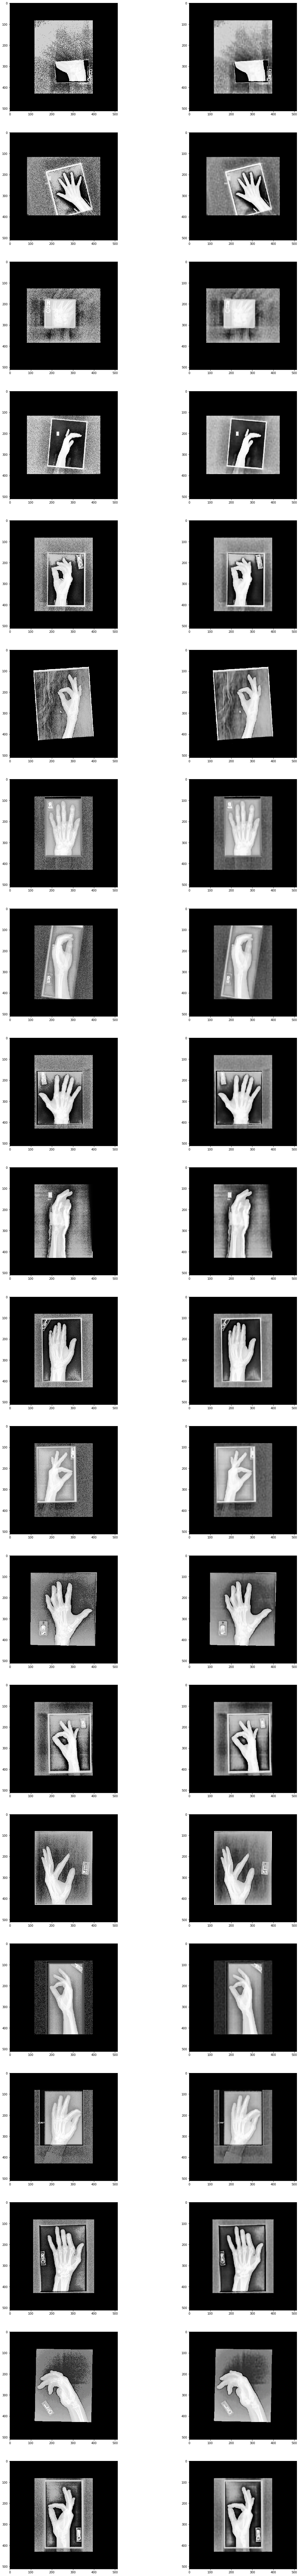

In [19]:
fig, ax = plt.subplots(nrows=size_sample, ncols=2, figsize=(20, 8*size_sample))

for i in range(size_sample):
    image_inp = files_true_positive[i]['image'][None,:,:,:]
    inp = image_inp.to(device)
    output = model(inp)
    
    ax[i, 0].imshow(image_inp.numpy()[0, 0, :, :], cmap='gray', vmin=0, vmax=1)
    ax[i, 1].imshow(output.detach().numpy()[0, 0, :, :], cmap='gray', vmin=0, vmax=1)

## 1.3 Loss per Epoch

In [20]:
augmentation_df_loss_1 = pd.read_csv(path_loss)
print(augmentation_df_loss_1)

     Unnamed: 0     train  validation
0             0  0.042210    0.046008
1             1  0.019258    0.019261
2             2  0.010950    0.012341
3             3  0.009083    0.009530
4             4  0.009650    0.008833
5             5  0.007830    0.007974
6             6  0.006620    0.007038
7             7  0.005949    0.007386
8             8  0.005815    0.007251
9             9  0.005578    0.006174
10           10  0.005306    0.005714
11           11  0.004792    0.005814
12           12  0.006013    0.005858
13           13  0.004831    0.005303
14           14  0.004812    0.005140
15           15  0.003966    0.005763
16           16  0.004734    0.005043
17           17  0.004573    0.004896
18           18  0.004590    0.005037
19           19  0.004233    0.005454
20           20  0.003602    0.004637
21           21  0.004433    0.004979
22           22  0.004209    0.004850
23           23  0.003561    0.004538
24           24  0.003694    0.004414
25          

Text(0.5, 1.0, 'Loss Augmentation: Flip')

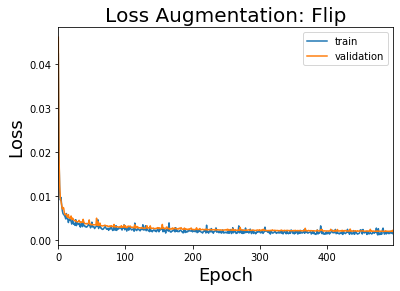

In [21]:
fig = augmentation_df_loss_1.plot.line(x = 'Unnamed: 0',
                                       y = ['train', 'validation'])
fig.set_xlabel('Epoch', fontsize=18)
fig.set_ylabel('Loss', fontsize=18)
fig.set_title('Loss Augmentation: Flip', fontsize=20)

The model seems not to overfit at 500 epochs. It looks like the loss is still decreasing with some outliers.